In [ ]:
# default_exp core

# Module core

> Nipype and mrtrix3 based pre-/post- processing pipeline for brain diffusion-MRI and generation of structural connectomes of the brain. This module contains customized and up-to-date command line interfaces that are not found from Nipype's interfaces module. Additionally, steps in the preprocessing pipeline are listed as standalone I/O modules as examples and simplified version of the pipeline

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#exporti
import os, sys
from nipype.interfaces.base import CommandLine, CommandLineInputSpec, File
from nipype.interfaces.base import TraitedSpec, traits
from nipype.interfaces.io import BIDSDataGrabber
from bids.layout import BIDSLayout

import nibabel as nb
from nilearn import plotting
from nilearn.image import new_img_like

from nipype.interfaces import fsl
from nipype.interfaces.freesurfer.preprocess import ReconAll
from nipype.interfaces.mrtrix3.utils import BrainMask, TensorMetrics, DWIExtract, MRMath
from nipype.interfaces.mrtrix3.preprocess import MRDeGibbs, DWIBiasCorrect
from nipype.interfaces.mrtrix3.reconst import FitTensor

Data input:

In [ ]:
#test
# if our sample data can create BIDS layouts
# data_dir = "/Users/xxie/sample_data/tinnitus2"
data_dir = 'data'
#layout = BIDSLayout(data_dir)
#assert len(layout.get_subjects()) != 0
#assert type(layout.get_subjects() is list)

layout = BIDSLayout(data_dir)
assert len(layout.get_subjects()) != 0
assert type(layout.get_subjects() is list)

## BIDS Data Input

#### Get subjects from BIDS directory:

In [ ]:
#export
def get_subs(sub_dir="data"):
    """
    Gets list of subjects in a BIDS directory, by default it looks in "data" folder in your CWD
    Input str of path to BIDS dir otherwise
    """
    print(
        "Creating layout of data directory, might take a while if there are a lot of subjects"
    )
    layout = BIDSLayout(sub_dir)
    sub_list = layout.get_subjects()
    ses_list = layout.get_sessions()
    return sub_list, ses_list, layout

In [ ]:
#test
sub_list, ses_list, layout = get_subs(data_dir)
print(sub_list)
print(ses_list)

Creating layout of data directory, might take a while if there are a lot of subjects
['11048']
['1']


In [ ]:
#test
import glob
#if subjects were all grabbed
assert len(get_subs(data_dir)[0]) == len(glob.glob(data_dir + '/sub-*'))
#if sessions were all grabbed
assert len(get_subs(data_dir)[1]) == len(glob.glob(data_dir + '/sub-*' + '/ses-*'))

Creating layout of data directory, might take a while if there are a lot of subjects
Creating layout of data directory, might take a while if there are a lot of subjects


#### Find FSL `.bval/.bvec` gradient file paths:

In [ ]:
#export
def get_bfiles_tuple(in_List):
    """
    read .bvec and .bval files in as a list and spit out tuple for nipype input
    """
    # bvs = layout.get(subject = sub_list[0], suffix = 'dwi', session = 1, extensions = ['bvec', 'bval'], return_type = 'file')
    bvs_tuple = tuple(in_List)[::-1]
    return bvs_tuple

In [ ]:
#test
bfiles = layout.get(
    subject=sub_list[0],
    suffix="dwi",
    session='1',
    extension=["bvec", "bval"],
    return_type="file",
) # here we are using session 002 as an example input
print(bfiles)
bfiles_fsl = get_bfiles_tuple(bfiles)
print(bfiles_fsl)
#if bfiles are grabbed
assert len(get_bfiles_tuple(bfiles)) == 2

['/Users/xxie/lab/pipetography/data/sub-11048/ses-1/dwi/sub-11048_ses-1_dwi.bval', '/Users/xxie/lab/pipetography/data/sub-11048/ses-1/dwi/sub-11048_ses-1_dwi.bvec']
('/Users/xxie/lab/pipetography/data/sub-11048/ses-1/dwi/sub-11048_ses-1_dwi.bvec', '/Users/xxie/lab/pipetography/data/sub-11048/ses-1/dwi/sub-11048_ses-1_dwi.bval')


#### Get dwi images:

In [ ]:
#test
dwi = layout.get(
    subject=sub_list[0],
    datatype="dwi",
    extension=[".nii", ".nii.gz"],
    return_type="file",
)
print(dwi)

['/Users/xxie/lab/pipetography/data/sub-11048/ses-1/dwi/sub-11048_ses-1_dwi.nii.gz']


In [ ]:
#test
#if all sessions are grabbed
assert len(dwi) == len(layout.get_sessions())

#### Get specific subject and session's gradient files:

In [ ]:
#export
def get_sub_gradfiles(sub_dwi, ext = 'nii.gz'):
    import os, sys
    """
    For a given layout and a subject's DWI, grab the matching gradient files
    """
    sub_bvec = sub_dwi.replace(ext, 'bvec')
    sub_bval = sub_dwi.replace(ext, 'bval')
    if os.path.exists(sub_bvec) and os.path.exists(sub_bval):
        grad_files = tuple([sub_bvec, sub_bval])
        return grad_files
    else:
        sys.exit('Gradient files missing for {}'.format(sub_dwi))

In [ ]:
#example
#usage
sub_grad_files = get_sub_gradfiles(dwi[0])
sub_grad_files

('/Users/xxie/lab/pipetography/data/sub-11048/ses-1/dwi/sub-11048_ses-1_dwi.bvec',
 '/Users/xxie/lab/pipetography/data/sub-11048/ses-1/dwi/sub-11048_ses-1_dwi.bval')

In [ ]:
#test
sub_grad_files = get_sub_gradfiles(dwi[0])
assert len(sub_grad_files) == 2

#### Get anatomical images:

In [ ]:
#example
#usage
anat = layout.get(
    subject=sub_list[0],
    datatype = 'anat',
    #session='002',
    extension=[".nii.gz"],
    return_type="filename",
)
print(anat)

[]


#### Convert anatomical images into freesurfer subject IDs with session specificity.

In [ ]:
#export

def anat2id(anat_files):
    """
    Takes input anat file BIDS names and creates freesurfer output directory names as inputs to subject_id
    The format of the output is [sub_id]_[session_id]
    """
    import os, re
    tmp_split = re.split('_', os.path.basename(anat_files))
    fs_subid = tmp_split[0] + '_' + tmp_split[1]

    return fs_subid

In [ ]:
#example
#usage

list_id = anat2id(anat_files=anat[0])
list_id

'sub-MINN294_ses-01'

#### Get BIDS JSON Metadata:

In [ ]:
#export

def BIDS_metadata(path, bids_dir):
    PEDIR = None
    from bids.layout import BIDSLayout
    bids_layout =  BIDSLayout(bids_dir)
    # total read out itme
    try:
        TRT = bids_layout.get_metadata(path)['TotalReadoutTime']
    except:
        print('No totalreadouttime in BIDS DWI JSON file, setting to default 0.1')
        TRT = 0.1
    # phase encoding direction
    try:
        PEDIR = bids_layout.get_metadata(path)['PhaseEncodingDirection']
    except KeyError:
        print('No phase encoding direction in JSON! Please add to all DWI JSON')

    return TRT, PEDIR

In [ ]:
#example
#usage

TRtime, pe_dir = BIDS_metadata(dwi[0], bids_dir = data_dir)
print('Total readout time is {}'.format(TRtime))
print('Phase encoding direction is {}'.format(pe_dir))

No totalreadouttime in BIDS DWI JSON file, setting to default 0.1
Total readout time is 0.1
Phase encoding direction is j-


In [ ]:
#test
TRtime, pe_dir = BIDS_metadata(dwi[0], bids_dir = data_dir)
assert pe_dir == 'j-'
assert TRtime == 0.1

No totalreadouttime in BIDS DWI JSON file, setting to default 0.1


/Users/xxie/miniconda3/envs/tracts/lib/python3.8/site-packages/bids/layout/models.py:98: FutureWarning: The 'extension' entity currently excludes the leading dot ('.'). As of version 0.14.0, it will include the leading dot. To suppress this warning and include the leading dot, use `bids.config.set_option('extension_initial_dot', True)`.
  warnings.warn("The 'extension' entity currently excludes the leading dot ('.'). "


In [ ]:
#exporti
class PipetographyBaseInputSpec(CommandLineInputSpec):
    export_grad = traits.Bool(
        argstr="-export_grad_mrtrix",
        desc="export new gradient files in mrtrix format",
        position=-4
    )
    export_fslgrad = traits.Bool(
        argstr="-export_grad_fsl",
        desc="export gradient files in fsl format",
        position = -6
    )
    out_fslgrad = traits.Tuple(
        File(desc="bvecs"),
        File(desc="bvals"),
        argstr="%s %s",
        desc="Output (bvecs, bvals) dw gradient scheme (FSL format)",
        position = -5
    )
    out_bfile = File(
        "dwi.b",
        argstr="%s",
        desc="name of new gradient file",
        position=-3
    )
    grad_fsl = traits.Tuple(
        (traits.Str, traits.Str),
        argstr="-fslgrad %s %s",
        desc="provide gradient table in fsl format",
        xor=["grad_fsl"]
    )
    grad_file = File(
        exists=True,
        argstr="-grad %s",
        desc="dw gradient scheme (MRTrix format)",
        xor=["grad_file"],
    )
    nthreads = traits.Int(
        argstr="-nthreads %d",
        desc="number of threads for mrtrix functions only. If zero, multi-threading is disabled",
        nohash=True,
    )
    force = traits.Bool(
        argstr="-force", desc="force output file if the file already exits"
    )
    quiet = traits.Bool(
        argstr="-quiet", desc="suppress verbose outputs"
    )

#### Concatenate images and gradients

For when there is a reverse phase encoding volume:

In [ ]:
#exporti
class MRCatInputSpec(CommandLineInputSpec):
    """inputs to mrtrix3's mrcat"""
    image1 = File(
        exists=True, mandatory=True, argstr="%s", position=1, desc="first input image"
    )
    image2 = File(
        exists=True, mandatory=True, argstr="%s", position=2, desc="additional input image"
    )
    out_file = File(
        mandatory=True, argstr="%s", position =3, desc="output image"
    )

class MRCatOutputSpec(TraitedSpec):
    """mrcat output file spec"""
    out_file = File(argstr="%s", desc="output image")

class MRCat(CommandLine):
    "Concatenate images"
    _cmd = "mrcat"
    input_spec = MRCatInputSpec
    output_spec = MRCatOutputSpec

    def _list_outputs(self):
        outputs = self.output_spec().get()
        outputs["out_file"] = os.path.abspath(self.inputs.out_file)
        return outputs

class GradCatInputSpec(CommandLineInputSpec):
    grad1 = File(
        argstr="%s", position = 1, desc="first gradient"
    )
    grad2 = File(
        argstr="%s", position = 2, desc="second gradient"
    )
    out_file = File(
        argstr="> %s", position = 3, desc="output gradient"
    )

class GradCatOutputSpec(TraitedSpec):
    """concatenated gradient file"""
    out_file = File(argstr="%s", desc="output gradient")

class GradCat(CommandLine):
    """concatenate gradients"""
    _cmd = "cat"
    input_spec = GradCatInputSpec
    output_spec = GradCatOutputSpec

    def  _list_outputs(self):
        outputs = self.output_spec().get()
        outputs["out_file"] = os.path.abspath(self.inputs.out_file)
        return outputs

In [ ]:
#example
#usage
catgrad = GradCat()
catgrad.inputs.grad1 = '/Users/xxie/sample_data/derivatives/pipetography/_subject_id_MINN294/mrtrix_image1/mapflow/_mrtrix_image10/raw_dwi1.b'
catgrad.inputs.grad2 = '/Users/xxie/sample_data/derivatives/pipetography/_subject_id_MINN294/mrtrix_image2/mapflow/_mrtrix_image20/raw_dwi2.b'
catgrad.inputs.out_file = '/Users/xxie/sample_data/derivatives/raw_dwi.b'
catgrad.run()

## ACPC MNI alignment (HCP Based), as seen on brainlife.io: 

This realigns our cropped anatomical image inputs to the MNI template using HCP pipeline procedure with FSL's `aff2rigid`. We want to do everything in MNI space.

In [ ]:
#exporti
class aff2rigidInputSpec(CommandLineInputSpec):
    """
    Specifying inputs to fsl's aff2rigid
    """
    in_file = File(
        exists=True, mandatory=True, argstr="%s", position=1, desc="FLIRT transform (12 DOF) from the input image to standard"
    )
    out_file = File(
        manndatory=True, argstr="%s", position=2, desc="output matrix which will go from the input image to standard space (6 DOF)"
    )

class aff2rigidOutputSpec(TraitedSpec):
    """
    Specifying outputs of aff2rigid
    """
    out_file = File(argstr="%s", desc="output matrix")

class fslaff2rigid(CommandLine):
    """
    Align cropped image the ACPC plane using FSL's aff2rigid
    """
    _cmd = "aff2rigid"
    input_spec = aff2rigidInputSpec
    output_spec = aff2rigidOutputSpec

    def _list_outputs(self):
        outputs = self.output_spec().get()
        outputs["out_file"] = os.path.abspath(self.inputs.out_file)
        return outputs

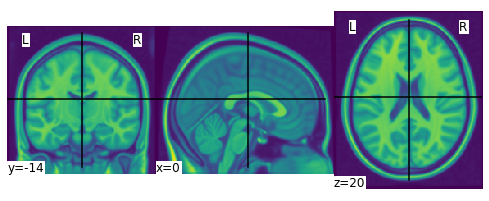

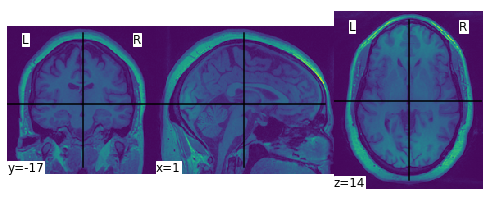

In [ ]:
#example
#usage

rfov = fsl.utils.RobustFOV() # first reduce FOV of T1 image
rfov.inputs.in_file = anat[0]
rfov.inputs.out_transform = 'outputs/roi2full.mat'
rfov.inputs.out_roi = 'outputs/robustfov.nii.gz'
rfov.run() # run RobustFOV

inv_xfm = fsl.utils.ConvertXFM() # inverse transformation matrix
inv_xfm.inputs.in_file = 'outputs/roi2full.mat'
inv_xfm.inputs.invert_xfm = True
inv_xfm.inputs.out_file = 'outputs/full2roi.mat'
inv_xfm.run() 

temp_ref = os.path.expandvars('$FSLDIR/data/standard/MNI152_T1_1mm.nii.gz')
flirt = fsl.preprocess.FLIRT()
flirt.inputs.in_file = 'outputs/robustfov.nii.gz'
flirt.inputs.reference = temp_ref
flirt.inputs.interp = 'spline'
flirt.inputs.out_matrix_file = 'outputs/roi2std.mat' 
flirt.inputs.out_file = 'outputs/acpc_mni.nii.gz'
flirt.run() # align acpc mni

concat = fsl.utils.ConvertXFM() # concatenate xfm
concat.inputs.in_file2 = 'outputs/roi2std.mat'
concat.inputs.in_file = 'outputs/full2roi.mat'
concat.inputs.concat_xfm = True
concat.inputs.out_file = 'outputs/full2std.mat'
concat.run()

affr = fslaff2rigid()
affr.inputs.in_file = 'outputs/full2std.mat'
affr.inputs.out_file = 'outputs/outputmatrix.mat'
affr.run()

warp = fsl.preprocess.ApplyWarp() # apply warp finally
warp.inputs.in_file = anat[0]
warp.inputs.relwarp = True
warp.inputs.interp = 'spline'
warp.inputs.ref_file = temp_ref
warp.inputs.out_file = 'outputs/acpc_t1.nii.gz'
warp.inputs.premat = 'outputs/outputmatrix.mat'
warp.run()

# if we visualize both the MNI template and aligned T1, they should be in the same coordinate system
template_img = nb.load(temp_ref)
template_data = template_img.get_fdata()
img = new_img_like(template_img, template_data, affine=template_img.affine, copy_header=True)
_ = plotting.plot_img(img)

acpc_img = nb.load('outputs/acpc_t1.nii.gz')
acpc_data = acpc_img.get_fdata()
t1_img = new_img_like(acpc_img, acpc_data, affine=acpc_img.affine, copy_header=True)
_ = plotting.plot_img(t1_img)

## Freesurfer `recon-all` for the ACPC-aligned image:

In [ ]:
#example
#usage
reconall = ReconAll()
reconall.inputs.directive = 'all'
# reconall.inputs.subject_id = 'sub-'+sub_list[0]
# reconall.inputs.subjects_dir = 'outputs/freesurfer'
reconall.inputs.subjects_dir = '/Users/xxie/sample_data/freesurfer'
reconall.inputs.T1_files = 'outputs/acpc_t1.nii'
reconall.inputs.hippocampal_subfields_T1 = True
reconall.inputs.parallel = True
reconall.inputs.openmp = 6
# reconall.cmdline
reconall.run()

!tree /Users/xxie/sample_data/freesurfer -L 2

/Users/xxie/sample_data/freesurfer
├── fsaverage -> /Applications/freesurfer/subjects/fsaverage
└── recon_all
    ├── label
    ├── mri
    ├── scripts
    ├── stats
    ├── surf
    ├── tmp
    ├── touch
    └── trash

10 directories, 0 files


## Convert to mrtrix3 image file format:

In [ ]:
#exporti
class ConvertInputSpec(PipetographyBaseInputSpec):
    in_file = File(
        exists=True, argstr="%s", mandatory=True, position=1, desc="input image"
    )
    out_file = File(
        "dwi.mif",
        argstr="%s",
        mandatory=True,
        position=2,
        usedefault=True,
        desc="output image",
    )
    coord = traits.List(
        traits.Int,
        sep=" ",
        argstr="-coord %s",
        desc="extract data at the specified coordinates",
    )
    vox = traits.List(
        traits.Float, sep=",", argstr="-vox %s", desc="change the voxel dimensions"
    )
    axes = traits.List(
        traits.Int,
        sep=",",
        argstr="-axes %s",
        desc="specify the axes that will be used",
    )
    scaling = traits.List(
        traits.Float,
        sep=",",
        argstr="-scaling %s",
        desc="specify the data scaling parameter",
    )
    export_json = traits.Bool(
        argstr="-json_export",
        desc="export image header to JSON file",
        position = -2
    )
    out_json = File(
        argstr="%s",
        desc="exported JSON file name",
        position = -1
    )

class ConvertOutputSpec(TraitedSpec):
    out_file = File(exists=True, desc="output image")
    out_bfile = File(desc="exported gradient file")
    out_fslbvec=File(desc="exported fsl gradient bvecs")
    out_fslbval=File(desc="exported fsl gradient bvals")
    out_json = File(desc="JSON with image header info")


class Convert(CommandLine):
    _cmd = "mrconvert"
    input_spec = ConvertInputSpec
    output_spec = ConvertOutputSpec

    def _list_outputs(self):
        outputs = self.output_spec().get()
        inputs = self.input_spec().get()
        outputs["out_file"] = os.path.abspath(self.inputs.out_file)
        if self.inputs.export_grad == True:
            outputs["out_bfile"] = os.path.abspath(self.inputs.out_bfile)
        if self.inputs.export_fslgrad == True:
            outputs["out_fslbvec"] = os.path.abspath(self.inputs.out_fslgrad[0])
            outputs["out_fslbval"] = os.path.abspath(self.inputs.out_fslgrad[1])
        if self.inputs.export_json == True:
            outputs["out_json"] = os.path.abspath(self.inputs.out_json)

        return outputs

#         try:
#             outputs["out_file"] = os.path.abspath(self.inputs.out_file)
#             outputs["out_bfile"] = os.path.abspath(self.inputs.out_bfile)
#             outputs["out_fslgrad"] = os.path.abspath(self.inputs.out_fslgrad)
#         except:
#             print('There is no output gradient file')
#         else:
#             outputs["out_file"] = os.path.abspath(self.inputs.out_file)
#         return outputs

In [ ]:
#example
#usage

# get session 2's dwi image:
dwi = layout.get(
    subject=sub_list[0],
    datatype="dwi",
    session='002',
    extensions=[".nii", ".nii.gz"],
    return_type='filename'
)
print(dwi)

mconvert = Convert()
mconvert.inputs.in_file = dwi[0]
mconvert.inputs.grad_fsl = bfiles_fsl
mconvert.inputs.out_file = 'outputs/raw_dwi.mif'
mconvert.inputs.export_grad = True
mconvert.inputs.out_bfile = 'outputs/raw_dwi.b'
mconvert.inputs.force = True
mconvert.run()

# check out the new bfile in mrtrix3 format:
!head -n 5 outputs/raw_dwi.b

['/Users/xxie/sample_data/BIDS_output/sub-01/ses-002/dwi/sub-01_ses-002_dwi.nii.gz']
# command_history: mrconvert -force -fslgrad /Users/xxie/sample_data/BIDS_output/sub-01/ses-002/dwi/sub-01_ses-002_dwi.bvec /Users/xxie/sample_data/BIDS_output/sub-01/ses-002/dwi/sub-01_ses-002_dwi.bval /Users/xxie/sample_data/BIDS_output/sub-01/ses-002/dwi/sub-01_ses-002_dwi.nii.gz -export_grad_mrtrix outputs/raw_dwi.b outputs/raw_dwi.mif  (version=3.0.0)
0 0 0 0
0.9921854444 0.07884946525 -0.09669956424 2000
0.3068129719 0.9514561533 0.02443334917 2000
-0.08367772189 0.4538619675 0.8871343491 2000


## Create DWI processing mask:

mrconvert: [WARNING] image "outputs/b0_mask.nii.gz" contains non-rigid transform - qform will not be stored.
mrconvert: [WARNING] requested datatype (Bit) not supported - substituting with UInt8
mrconvert: [100%] copying from "outputs/b0_brain_dwi_mask.mif" to "outputs/b0_mask.nii.gz"
mrconvert: [100%] compressing image "outputs/b0_mask.nii.gz"


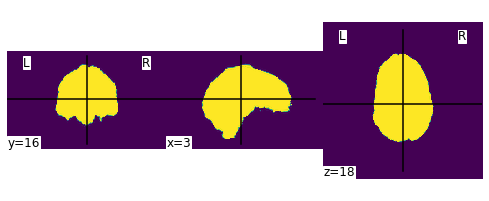

In [ ]:
#example
#usage

createMask = BrainMask()
createMask.inputs.in_file = 'outputs/raw_dwi.mif'
createMask.inputs.out_file = 'outputs/brain_dwi_mask.mif'
createMask.run()

# visualize mask:
!mrconvert outputs/brain_dwi_mask.mif outputs/brain_dwi_mask.nii.gz
b0mask = nb.load('outputs/brain_dwi_mask.nii.gz')  # display dwi
mask_data = b0mask.get_fdata()
img = new_img_like(b0mask, mask_data, affine=b0mask.affine, copy_header=True)
_ = plotting.plot_img(img)

## Check gradient orientations and create corrected image:
The `dwigradcheck` functionality hasn't appeared in Nipype interfaces yet so we add it here

In [ ]:
#exporti
class GradCheckInputSpec(PipetographyBaseInputSpec):
    in_file = File(
        exists=True,
        mandatory=True,
        argstr = '%s',
        position = 1,
        desc = "input DWI"
    )
    mask_file = File(
        exists=True,
        argstr="-mask %s",
        position = 3,
        desc = "input brain mask image option"
    )
    tract_number = traits.Int(
        argstr="-number %d",
        desc="number of tracts generated for each test",
        nohash=True,
    )

class GradCheckOutputSpec(TraitedSpec):
    out_bfile = File(
        argstr='%s', desc = "corrected gradient file"
    )

class GradCheck(CommandLine):
    """
    Check the input DWI's gradients with a provided brain mask and output the corrected gradients
    """
    _cmd = "dwigradcheck"
    input_spec = GradCheckInputSpec
    output_spec = GradCheckOutputSpec

    def _list_outputs(self):
        outputs = self.output_spec().get()
        outputs["out_bfile"] = os.path.abspath(self.inputs.out_bfile)
        return outputs

In [ ]:
#example
#usage

gradcheck = GradCheck()
gradcheck.inputs.mask_file = 'outputs/brain_dwi_mask.mif'
gradcheck.inputs.in_file = 'outputs/raw_dwi.mif'
gradcheck.inputs.export_grad = True
gradcheck.inputs.out_bfile = 'outputs/corrected.b'
gradcheck.inputs.grad_file = 'outputs/raw_dwi.b'
gradcheck.inputs.force = True
gradcheck.cmdline
gradcheck.run()

# create new dwi image with corrected gradients:
mconvert = Convert()
mconvert.inputs.in_file = 'outputs/raw_dwi.mif'
mconvert.inputs.grad_file = 'outputs/corrected.b'
mconvert.inputs.out_file = 'outputs/cdwi.mif'
mconvert.inputs.force = True
mconvert.run()

# we should have the following mrtrix3 image files going into the preprocessing stages
!tree outputs -L 2 | grep .mif

There is no output gradient file
├── b0_brain_dwi_mask.mif
├── cdwi.mif
├── raw_dwi.mif


## Denoise DWI:
This command exists in `nipype.interface`, but is missing some flags: 

In [ ]:
#exporti
class dwidenoiseInputSpec(PipetographyBaseInputSpec):
    """
    Specifying inputs to dwidenoise
    """

    in_file = File(
        exists=True, mandatory=True, argstr="%s", position=1, desc="input image"
    )
    noise = File(
        mandatory=True, argstr="-noise %s", position=2, desc="output noise map"
    )
    out_file = File(
        mandatory=True, argstr="%s", position=-1, desc="output denoised image"
    )


class dwidenoiseOutputSpec(TraitedSpec):
    """
    Specifying outputs of dwidenoise
    """

    noise = File(argstr="%s", desc="output noise level map")
    out_file = File(argstr="%s", desc="output denoised file")


class dwidenoise(CommandLine):
    """
    Denoise DWI data with mrtrix3's dwidenoise.
    This should be performed as the first step of the preprocessing pipeline!
    Arguments:
        in_file (str): Input DWI image
        noise (str): output noise map
        out_file (str): output denoised image
        nthreads (int): number of threads to use
    """

    _cmd = "dwidenoise"
    input_spec = dwidenoiseInputSpec
    output_spec = dwidenoiseOutputSpec

    def _list_outputs(self):
        outputs = self.output_spec().get()
        outputs["noise"] = os.path.abspath(self.inputs.noise)
        outputs["out_file"] = os.path.abspath(self.inputs.out_file)
        return outputs

mrconvert: [WARNING] existing output files will be overwritten
mrconvert: [WARNING] image "outputs/cdwi.nii.gz" contains non-rigid transform - qform will not be stored.
mrconvert: [100%] copying from "outputs/cdwi.mif" to "outputs/cdwi.nii.gz"
mrconvert: [100%] compressing image "outputs/cdwi.nii.gz"


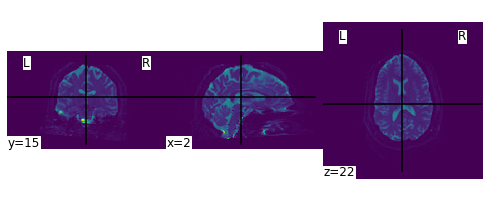

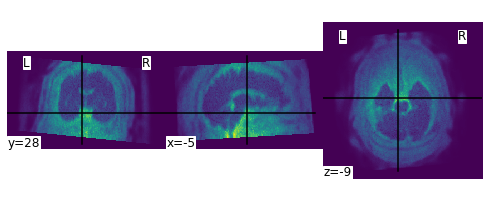

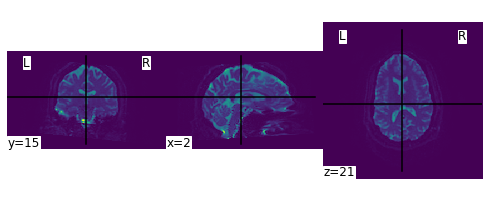

In [ ]:
#example
#usage:

# we will work with .nii.gz format for simpler visualization
denoise = dwidenoise()
denoise.inputs.out_file = "outputs/denoised.nii.gz"
denoise.inputs.noise = "outputs/noise.nii.gz"
denoise.inputs.in_file = "outputs/cdwi.mif"  # the first session's image
denoise.inputs.force = True
denoise.run()

# visualize:
!mrconvert outputs/cdwi.mif outputs/cdwi.nii.gz -force

orig_dwi = nb.load('outputs/cdwi.nii.gz')  # display dwi
orig_data = orig_dwi.get_fdata()[:, :, :, 0]
orig_img = new_img_like(orig_dwi, orig_data, affine=orig_dwi.affine, copy_header=True)
_ = plotting.plot_img(orig_img)

_ = plotting.plot_img(denoise.inputs.noise)

denoised_dwi = nb.load(denoise.inputs.out_file)
denoised_data = denoised_dwi.get_fdata()[:, :, :, 0]
denoised_img = new_img_like(
    denoised_dwi, denoised_data, affine=denoised_dwi.affine, copy_header=True
)
_ = plotting.plot_img(denoised_img)

In [ ]:
# if denoised file exists
#from fastcore.test import *
#
#test_eq(os.path.exists(denoise.inputs.noise), True)
#test_eq(os.path.exists(denoise.inputs.out_file), True)

## Gibb's ringing artifact removal:
You should run this step after denoise so you don't change the noise patterns before denoising. And this should also be done before `dwifslpreproc`.

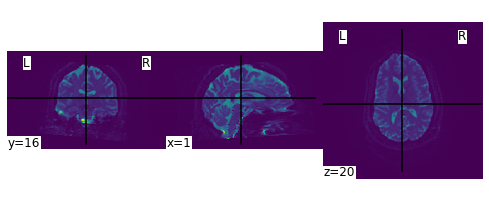

In [ ]:
#example
#usage

DeGibbs = MRDeGibbs()
DeGibbs.inputs.in_file  = 'outputs/denoised.nii.gz'
DeGibbs.inputs.out_file = 'outputs/degibbs.nii.gz'
DeGibbs.run()

# visualize:
degibbs_dwi = nb.load(DeGibbs.inputs.out_file)
degibbs_data = degibbs_dwi.get_fdata()[:, :, :, 0]
degibbs_img = new_img_like(
    degibbs_dwi, degibbs_data, affine=degibbs_dwi.affine, copy_header=True
)
_ = plotting.plot_img(degibbs_img)

## DWI Distortion correction
`dwipreproc` Was recently updated to `dwifslpreproc`, so we create the following commandline inputs, also `dwipreproc` doesn't exist in `Nipype`'s mrtrix3 interface:

In [ ]:
#exporti
class dwipreprocInputSpec(PipetographyBaseInputSpec):
    in_file = File(
        exists=True,
        mandatory=True,
        argstr="%s",
        position=0,
        desc="input denoised, Gibbs artifact removed file",
    )
    rpe_options = traits.Str(
        mandatory=True,
        argstr="%s",
        position=3,
        desc="acquisition phase-encoding design",
    )
    pe_dir = traits.Str(
        mandatory=True, argstr="-pe_dir %s", position=4, desc="phase encoding direction"
    )
    eddy_options = traits.Str(
        mandatory=False,
        argstr="-eddy_options %s",
        position=2,
        desc="eddy command options within quotation marks and contains at least one space",
    )
    out_file = File(
        mandatory=True,
        argstr="%s",
        position=1,
        desc="output denoised, corrected, preproc image",
    )
    RO_time = traits.Float(
        argstr='-readout_time %f',
        position=-1,
        desc='total read out time, if unspecified defaults to 0.1'
    )


class dwipreprocOutputSpec(TraitedSpec):
    out_file = File(argstr="%s", desc="output denoised, corrected, preproc image")
    out_bfile = File(argstr="%s", desc="eddy corrected gradients")


class dwipreproc(CommandLine):
    """
    mrtrix3 dwipreproc for motion/eddy current correction
    Arguments:
        in_file (str): input file that needs the artifact correction
        rpe_options (str): phase-encoding design, see mrtrix3's dwipreproc for detail options
        pe_dir (str): phase encoding directions, see mrtrix3's dwipreproc for detail options
        eddy_options (str): eddy current correction options. see mrtrix3's dwipreproc for detail options
        nthreads (int): number of threads used
        grad_fsl (tuple): bvec/bval files
        out_file (str): file name and path for output
    Returns:
        out_file (str): preprocessed file, this is the input to tractography.
    """

    _cmd = "dwifslpreproc"
    input_spec = dwipreprocInputSpec
    output_spec = dwipreprocOutputSpec

    def _list_outputs(self):
        outputs = self.output_spec().get()
        outputs["out_file"] = os.path.abspath(self.inputs.out_file)
        if self.inputs.export_grad == True:
            outputs["out_bfile"] = os.path.abspath(self.inputs.out_bfile)
        return outputs

dwifslpreproc outputs/degibbs.nii.gz outputs/preproc.nii.gz -eddy_options "--slm=linear " -rpe_none -pe_dir j -force -grad outputs/corrected.b -readout_time 0.165240


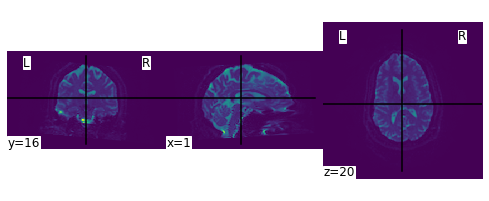

In [ ]:
#example
#usage

# this example is for basic DWI acquisition
# all image volumes are acquired in a single protocol with fixed phase encoding:
preproc = dwipreproc()
preproc.inputs.in_file = 'outputs/degibbs.nii.gz' 
preproc.inputs.rpe_options = "-rpe_none"
preproc.inputs.eddy_options = '"--slm=linear --repol"'
preproc.inputs.out_file = "outputs/preproc.nii.gz"
preproc.inputs.grad_file = gradcheck.inputs.out_bfile
preproc.inputs.force = True
# PyBIDS Can also extract meta data:
preproc.inputs.RO_time = layout.get_metadata(dwi[0])['TotalReadoutTime']
preproc.inputs.pe_dir = layout.get_metadata(dwi[0])['PhaseEncodingDirection']
print(preproc.cmdline)
preproc.run()

# visualize:
preproc_dwi = nb.load(preproc.inputs.out_file)
preproc_data = preproc_dwi.get_fdata()[:, :, :, 0]
preproc_img = new_img_like(
    preproc_dwi, preproc_data, affine=preproc_dwi.affine, copy_header=True
)
_ = plotting.plot_img(preproc_img)

## Bias field correction with ANTS:
There are 3 important parameters:

`ants.b`: default is [100,3], the values stand for [Initial mesh resolution in mm, spline order]. ANTS' N4BiasFieldCorrection option -b. This value is optimised for human adult data and needs to be adjusted for rodent data.

`ants.c`: default is [1000,0.0] or [numberOfIterations,convergenceThreshold], Equivalent to ANTS' N4BiasFieldCorrection option -c. 

`ants.s`: default is 4 N4BiasFieldCorrection option -s. shrink-factor applied to spatial dimensions

The current `Nipype` interface doesn't support the additional commandline arguments for `ANTS` in the correct order, AND their flags for certain inputs are outdated. So we create our own:

In [ ]:
#exporti
class BiasCorrectInputSpec(PipetographyBaseInputSpec):
    in_file = File(
        exists=True, argstr="%s", position=1, mandatory=True, desc="input DWI image"
    )
    in_mask = File(argstr="-mask %s", desc="input mask image for bias field estimation")
    use_ants = traits.Bool(
        argstr="ants",
        mandatory=True,
        desc="use ANTS N4 to estimate the inhomogeneity field",
        position = 0,
        xor=["use_fsl"],
    )
    use_fsl = traits.Bool(
        argstr="fsl",
        mandatory=True,
        desc="use FSL FAST to estimate the inhomogeneity field",
        position = 0,
        xor=["use_ants"],
    )
    bias = File(argstr="-bias %s", desc="bias field")
    out_file = File(
        name_template="%s_biascorr",
        name_source="in_file",
        keep_extension=True,
        argstr="%s",
        position=2,
        desc="the output bias corrected DWI image",
        genfile=True,
    )
    args = traits.Str(
        argstr="%s",
        desc="additional arguments to ANTS or FSL",
        position=1
    )


class BiasCorrectOutputSpec(TraitedSpec):
    bias = File(desc="the output bias field", exists=True)
    out_file = File(desc="the output bias corrected DWI image", exists=True)


class BiasCorrect(CommandLine):
    _cmd = "dwibiascorrect"
    input_spec = BiasCorrectInputSpec
    output_spec = BiasCorrectOutputSpec
    def _list_outputs(self):
        outputs = self.output_spec().get()
        outputs["out_file"] = os.path.abspath(self.inputs.out_file)
        outputs['bias'] = os.path.abspath(self.inputs.bias)
        # Get the attribute saved during _run_interface
        return outputs

dwibiascorrect ants outputs/preproc.nii.gz outputs/dwi_bias.nii.gz -bias outputs/biasfield.nii.gz -grad outputs/corrected.b


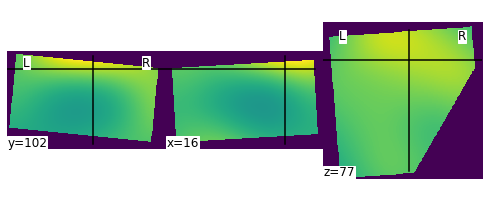

In [ ]:
#example
#usage

N4BiasCorrect = BiasCorrect()
N4BiasCorrect.inputs.use_ants = True
N4BiasCorrect.inputs.in_file = preproc.inputs.out_file
N4BiasCorrect.inputs.out_file = 'outputs/dwi_bias.nii.gz'
N4BiasCorrect.inputs.bias = 'outputs/biasfield.nii.gz'
N4BiasCorrect.inputs.grad_file = gradcheck.inputs.out_bfile
# We use the default values provided by brainlife.io as a test:
N4BiasCorrect.inputs.args = "-ants.b [150,3] -ants.c [200x200, 1e-6] -ants.s 2"
print(N4BiasCorrect.cmdline)
N4BiasCorrect.run()

# visualize the output bias field:
bias_dwi = nb.load(N4BiasCorrect.inputs.bias)
bias_data = bias_dwi.get_fdata() # try ...
bias_img = new_img_like(
    bias_dwi, bias_data, affine=bias_dwi.affine, copy_header=True
)
_ = plotting.plot_img(bias_img)

## Rician Noise Removal:

Functions we will use: `mrinfo`, `mrcalc`, and the already interfaced `mrconvert`

In [ ]:
#exporti
class MRInfoInputSpec(PipetographyBaseInputSpec):
    in_file = File(
        exists=True, argstr="%s", position=1, mandatory=True, desc="input DWI image"
    )
    args = traits.Str(
        argstr="%s",
        desc="options arguments to mrinfo",
        position=0
    )

class MRInfoOutputSpec(TraitedSpec):
    out_bfile = File(
        argstr='%s', desc = "Output gradient file"
    )

class MRInfo(CommandLine):
    _cmd = "mrinfo"
    input_spec = MRInfoInputSpec
    output_spec = MRInfoOutputSpec

    def _list_outputs(self):
        outputs = self.output_spec().get()
        try:
            outputs["out_bfile"] = os.path.abspath(self.inputs.out_bfile)
        except:
            print('There is no output gradient file')
        return outputs

In [ ]:
#example
#usage

# generate new gradient after bias correct
grad_info = MRInfo()
grad_info.inputs.in_file = N4BiasCorrect.inputs.out_file
grad_info.inputs.grad_file = gradcheck.inputs.out_bfile
grad_info.inputs.export_grad = True
grad_info.inputs.out_bfile = 'outputs/RCNtmp.b'
grad_info.inputs.force = True
print(grad_info.cmdline)
grad_info.run()

# check:
!head -n 5 outputs/RCNtmp.b

mrinfo outputs/dwi_bias.nii.gz -force -grad outputs/corrected.b -export_grad_mrtrix outputs/RCNtmp.b
# command_history: mrinfo outputs/dwi_bias.nii.gz -force -grad outputs/corrected.b -export_grad_mrtrix outputs/RCNtmp.b  (version=3.0.0)
0 0 0 0
0.9921854444 0.07884946525 -0.09669956424 2000
0.3068129719 0.9514561533 0.02443334917 2000
-0.08367772189 0.4538619675 0.8871343491 2000


In [ ]:
#exporti
class CheckFiniteInputSpec(PipetographyBaseInputSpec):
    out_file = File(
        mandatory=True, argstr="%s", position=4, desc="output file name"
    )
    isfinite = traits.Str(
        argstr = "%s -finite",
        desc = "Not NaN or Inf per voxel",
        position = 1
    )

class CheckFiniteOutputSpec(TraitedSpec):
    out_file = File(desc = "output file", exists=True)

class CheckFinite(CommandLine):
    _cmd = "mrcalc"
    input_spec = CheckFiniteInputSpec
    output_spec = CheckFiniteOutputSpec
    def _list_outputs(self):
        outputs = self.output_spec().get()
        return outputs

class CompareIfInputSpec(PipetographyBaseInputSpec):
    out_file = File(
        mandatory=True, argstr="%s", position=4, desc="output file name"
    )
    cond_if = traits.Str(
        argstr = "%s 0 -if",
        desc = "If first one is true, return second, if not return third",
        position = 1
    )

class CompareIfOutputSpec(TraitedSpec):
    out_file = File(desc = "output file",  exists=True)

class CompareIf(CommandLine):
    _cmd = "mrcalc"
    input_spec = CompareIfInputSpec
    output_spec = CompareIfOutputSpec
    def _list_outputs(self):
        outputs = self.output_spec().get()
        return outputs

In [ ]:
#exporti
class CheckNIZInputSpec(PipetographyBaseInputSpec):
    in_file = File(
        exists=True, argstr="%s", position=0, desc="input image"
    )
    out_file = File(
        mandatory=True, argstr="%s", position=4, desc="output file name", genfile=True
    )
    isfinite = traits.Str(
        argstr="%s -finite",
        desc="not NaN or Inf",
        position=1
    )
    cond_if = traits.Str(
        argstr="%s 0 -if",
        desc="return operand that's True",
        position=2
    )
    args = traits.Str(
        argstr="%s",
        desc="options arguments to mrcalc",
        position=3
    )

class CheckNIZOutputSpec(TraitedSpec):
    out_file = File(desc = "Output file", exists=True)

class CheckNIZ(CommandLine):
    _cmd = "mrcalc"
    input_spec = CheckNIZInputSpec
    output_spec = CheckNIZOutputSpec
    def _list_outputs(self):
        outputs = self.output_spec().get()
        outputs["out_file"] = os.path.abspath(self.inputs.out_file)
        return outputs

mrcalc outputs/noise.nii.gz -finite outputs/noise.nii.gz 0 -if outputs/lownoisemap.nii.gz -force -nthreads 6 -quiet


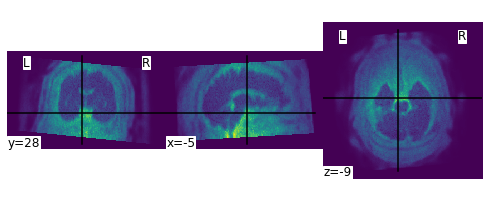

In [ ]:
#example
#usage
CheckNoise = CheckNIZ()
CheckNoise.inputs.out_file = 'outputs/lownoisemap.nii.gz'
CheckNoise.inputs.isfinite = 'outputs/noise.nii.gz'
CheckNoise.inputs.cond_if = 'outputs/noise.nii.gz'
CheckNoise.inputs.force = True
CheckNoise.inputs.quiet = True
CheckNoise.inputs.nthreads = 6
print(CheckNoise.cmdline)
CheckNoise.run()

# visualize:
lownoise_dwi = nb.load(CheckNoise.inputs.out_file)
lownoise_data = lownoise_dwi.get_fdata() # try ...
lownoise_img = new_img_like(
   lownoise_dwi, lownoise_data, affine=lownoise_dwi.affine, copy_header=True
)
_ = plotting.plot_img(lownoise_img)

In [ ]:
#exporti
class RicianNoiseInputSpec(PipetographyBaseInputSpec):
    in_file = File(
        exists=True, argstr="%s", position=0, mandatory=True, desc="input dwi image"
    )
    power = traits.Int(
        argstr="%d -pow",
        position = 1,
        desc = "raise to the power of"
    )
    lownoisemap = File(
            exists=True, argstr="%s", position=2, desc="low noise map image"
    )
    denoise = traits.Int(
        argstr="%d -pow -sub -abs -sqrt",
        position=3,
        desc="denoise math operation"
    )
    out_file = File(
        argstr="%s", position=4, mandatory=True, desc="output DWI denoised image",
        genfile=True,
    )


class RicianNoiseOutputSpec(TraitedSpec):
    out_file = File(desc = "output DWI image", exists=True)


class RicianNoise(CommandLine):
    _cmd = "mrcalc"
    input_spec = RicianNoiseInputSpec
    output_spec = RicianNoiseOutputSpec
    def _list_outputs(self):
        outputs = self.output_spec().get()
        outputs["out_file"] = os.path.abspath(self.inputs.out_file)
        return outputs

mrcalc outputs/dwi_bias.nii.gz 2 -pow outputs/lownoisemap.nii.gz 2 -pow -sub -abs -sqrt outputs/RCN_dwi.mif -force
mrcalc outputs/RCN_dwi.mif -finite outputs/RCN_dwi.mif 0 -if -force outputs/RCN_tmp.mif
There is no output gradient file
mrconvert -force -grad outputs/RCNtmp.b outputs/RCN_tmp.mif outputs/rician_corrected_dwi.mif
mrconvert: [WARNING] existing output files will be overwritten
mrconvert: [WARNING] image "outputs/rician_corrected_dwi.nii.gz" contains non-rigid transform - qform will not be stored.
mrconvert: [100%] copying from "outputs/rician_corrected_dwi.mif" to "outputs/rician_corrected_dwi.nii.gz"
mrconvert: [100%] compressing image "outputs/rician_corrected_dwi.nii.gz"


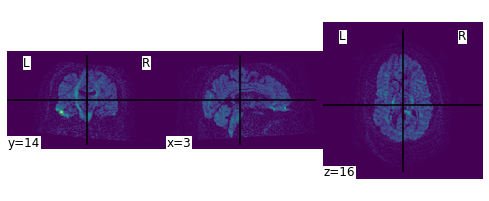

In [ ]:
#example
#usage

RCNRemoval = RicianNoise()
RCNRemoval.inputs.in_file = N4BiasCorrect.inputs.out_file
RCNRemoval.inputs.power = 2
RCNRemoval.inputs.lownoisemap = CheckNoise.inputs.out_file
RCNRemoval.inputs.denoise = 2
RCNRemoval.inputs.out_file = 'outputs/RCN_dwi.mif'
RCNRemoval.inputs.force=True
print(RCNRemoval.cmdline)
RCNRemoval.run()

# We need to do noise comparison with the DWI's instead of noise files:
CheckDWI = CheckNIZ()
CheckDWI.inputs.out_file = 'outputs/RCN_tmp.mif'
CheckDWI.inputs.isfinite = 'outputs/RCN_dwi.mif'
CheckDWI.inputs.cond_if = 'outputs/RCN_dwi.mif'
CheckDWI.inputs.force = True
print(CheckDWI.cmdline)
CheckDWI.run()

# Create rician noise removed image:
RCN_convert = Convert()
RCN_convert.inputs.in_file = CheckDWI.inputs.out_file
RCN_convert.inputs.grad_file =  grad_info.inputs.out_bfile
RCN_convert.inputs.out_file = 'outputs/rician_corrected_dwi.mif'
RCN_convert.inputs.force = True
RCN_convert.run()
print(RCN_convert.cmdline)

# visualize:
!mrconvert outputs/rician_corrected_dwi.mif outputs/rician_corrected_dwi.nii.gz -force
rician_dwi = nb.load('outputs/rician_corrected_dwi.nii.gz')
rician_data = rician_dwi.get_fdata()[:,:,:,2] # try ...
rician_img = new_img_like(
    rician_dwi, rician_data, affine=rician_dwi.affine, copy_header=True
)
_ = plotting.plot_img(rician_img)

## Image Intensity Normalization:
First we recreate brain mask for DWI:

mrconvert: [WARNING] image "outputs/dwi_mask.nii.gz" contains non-rigid transform - qform will not be stored.
mrconvert: [WARNING] requested datatype (Bit) not supported - substituting with UInt8
mrconvert: [100%] copying from "outputs/dwi_mask.mif" to "outputs/dwi_mask.nii.gz"
mrconvert: [100%] compressing image "outputs/dwi_mask.nii.gz"


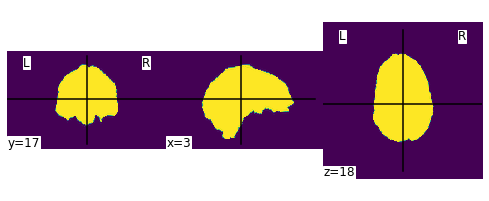

In [ ]:
#example
#usage

createMask = BrainMask()
createMask.inputs.in_file = 'outputs/rician_corrected_dwi.mif'
createMask.inputs.out_file = 'outputs/dwi_mask.mif'
createMask.run()

# visualize mask:
!mrconvert outputs/dwi_mask.mif outputs/dwi_mask.nii.gz
mask = nb.load('outputs/dwi_mask.nii.gz')  # display dwi
mask_data = mask.get_fdata()
img = new_img_like(mask, mask_data, affine=mask.affine, copy_header=True)
_ = plotting.plot_img(img)

Then createt FA WM mask, we first use `Nipype` provided `dwi2tensor` and `tensor2metric` interfaces, then create a threshold interface that's unavailable from `Nipype`:

In [ ]:
#exporti

class MRThresholdInputSpec(PipetographyBaseInputSpec):
    opt_abs = traits.Float(
        argstr="-abs %f",
        desc="absolute intensity",
        position=0,
        xor=["opt_per", "opt_top", "opt_bot"]
    )
    opt_per = traits.Float(
        argstr="-percentile %f",
        desc="percentile of image intensity",
        position=0,
        xor=["opt_abs", "opt_top", "opt_bot"]
    )
    opt_top = traits.Float(
        argstr="-top %f",
        desc="number of top-value image intensities",
        position=0,
        xor=["opt_abs", "opt_per", "opt_bot"]
    )
    opt_bot = traits.Float(
        argstr="-bot %f",
        desc="number of bottom valued voxels",
        position=0,
        xor=["opt_abs", "opt_top", "opt_per"]
    )
    in_file = File(
        exists=True,
        mandatory=True,
        argstr="%s",
        desc="input file path",
        position=1
    )
    out_file = File(
        argstr="%s",
        desc="output file path/name",
        position=2
    )

class MRThresholdOutputSpec(TraitedSpec):
    out_file = File(desc = "output thresholded image")

class MRThreshold(CommandLine):
    _cmd = "mrthreshold"
    input_spec = MRThresholdInputSpec
    output_spec = MRThresholdOutputSpec
    def _list_outputs(self):
        outputs = self.output_spec().get()
        outputs["out_file"] = os.path.abspath(self.inputs.out_file)
        return outputs

dwi2tensor -mask outputs/dwi_mask.mif outputs/rician_corrected_dwi.mif outputs/dti.mif
tensor2metric -num 1 -fa outputs/fa.mif outputs/dti.mif
mrthreshold -abs 0.500000 outputs/fa.mif outputs/wm.mif
mrconvert: [WARNING] image "outputs/wm.nii.gz" contains non-rigid transform - qform will not be stored.
mrconvert: [WARNING] requested datatype (Bit) not supported - substituting with UInt8
mrconvert: [100%] copying from "outputs/wm.mif" to "outputs/wm.nii.gz"/wm.mif" to "outputs/wm.nii.gz"... 
mrconvert: [100%] compressing image "outputs/wm.nii.gz"


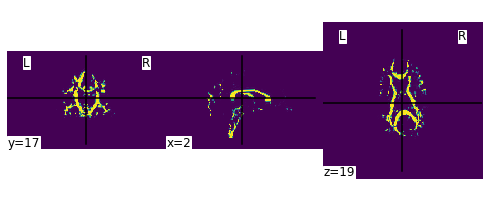

In [ ]:
#example
#usage
makeDTI = FitTensor()
makeDTI.inputs.in_file = 'outputs/rician_corrected_dwi.mif'
makeDTI.inputs.in_mask = 'outputs/dwi_mask.mif'
makeDTI.inputs.out_file = 'outputs/dti.mif'
print(makeDTI.cmdline)
makeDTI.run()

GetFA = TensorMetrics()
GetFA.inputs.in_file = 'outputs/dti.mif'
GetFA.inputs.out_fa = 'outputs/fa.mif'
print(GetFA.cmdline)
GetFA.run()

WMThresh = MRThreshold()
WMThresh.inputs.in_file = 'outputs/fa.mif'
WMThresh.inputs.opt_abs = 0.5
WMThresh.inputs.out_file = 'outputs/wm.mif'
print(WMThresh.cmdline)
WMThresh.run()

#visualize WM image:
!mrconvert outputs/wm.mif outputs/wm.nii.gz
wm = nb.load('outputs/wm.nii.gz')  # display dwi
wm_data = wm.get_fdata()
img = new_img_like(wm, wm_data, affine=wm.affine, copy_header=True)
_ = plotting.plot_img(img)

Now we can normalize the white matter signal:

In [ ]:
#exporti
class DWINormalizeInputSpec(PipetographyBaseInputSpec):
    opt_intensity = traits.Float(
        argstr="-intensity %f",
        desc="Normalise the b=0 signal to a specified value (Default: 1000)",
        position=0,
    )
    opt_percent = traits.Int(
        argstr="-percentile %d",
        desc="Define the percentile of the b=0 image intensties within the mask used for normalisation",
        position=0,
    )
    in_file = File(
        exists=True,
        mandatory=True,
        argstr="%s",
        desc="input file path",
        position=1
    )
    mask_file = File(
        argstr="%s",
        desc="The mask within which a reference b=0 intensity will be sampled",
        position=2
    )
    out_file = File(
        argstr="%s",
        desc="output file path/name",
        position=3
    )

class DWINormalizeOutputSpec(TraitedSpec):
    out_file = File(desc = "output thresholded image")

class DWINormalize(CommandLine):
    _cmd="dwinormalise individual"
    input_spec=DWINormalizeInputSpec
    output_spec=DWINormalizeOutputSpec
    def _list_outputs(self):
        outputs = self.output_spec().get()
        outputs["out_file"] = os.path.abspath(self.inputs.out_file)
        return outputs

dwinormalise individual -intensity 1000.000000 outputs/rician_corrected_dwi.mif outputs/wm.mif -force outputs/dwi_norm.mif
mrconvert: [WARNING] image "outputs/dwi_norm.nii.gz" contains non-rigid transform - qform will not be stored.
mrconvert: [100%] copying from "outputs/dwi_norm.mif" to "outputs/dwi_norm.nii.gz"
mrconvert: [100%] compressing image "outputs/dwi_norm.nii.gz"


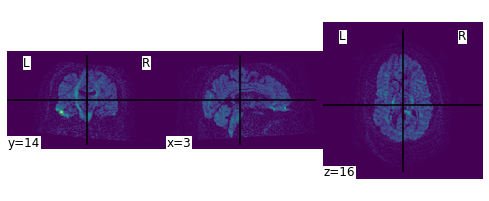

In [ ]:
#example
#usage
normalize = DWINormalize()
normalize.inputs.opt_intensity = 1000
normalize.inputs.in_file = 'outputs/rician_corrected_dwi.mif'
normalize.inputs.out_file = 'outputs/dwi_norm.mif'
normalize.inputs.mask_file = 'outputs/wm.mif'
normalize.inputs.force=True
print(normalize.cmdline)
normalize.run()

#visualize
!mrconvert outputs/dwi_norm.mif outputs/dwi_norm.nii.gz -force
norm = nb.load('outputs/dwi_norm.nii.gz')  # display dwi
norm_data = norm.get_fdata()[:,:,:,2] # try non-B0 volume
img = new_img_like(norm, norm_data, affine=norm.affine, copy_header=True)
_ = plotting.plot_img(img)

## Create B0 Volume and Mask with cleaned-up DWIs:

In [ ]:
#example
#usage

# extract B0 volume
B0Extract = DWIExtract()
B0Extract.inputs.bzero = True
B0Extract.inputs.in_file = 'outputs/dwi_norm.mif' # intensity normalized dwi volume
B0Extract.inputs.out_file = 'outputs/b0_volumes.mif'
B0Extract.run()

# find mean B0 volume
B0Mean = MRMath()
B0Mean.inputs.operation = 'mean'
B0Mean.inputs.in_file = 'outputs/b0_volumes.mif'
B0Mean.inputs.axis = 3
B0Mean.inputs.out_file = 'outputs/b0_dwi.mif'
B0Mean.run()

# create DWI B0 mask
B0Mask = BrainMask()
B0Mask.inputs.in_file = 'outputs/dwi_norm.mif'
B0Mask.inputs.out_file = 'outputs/dwi_norm_mask.mif'
B0Mask.run()

# do a simple conversion to nifti format for FSL input 
!mrconvert outputs/b0_dwi.mif outputs/b0_dwi.nii.gz -force
!mrconvert outputs/dwi_norm_mask.mif outputs/dwi_norm_mask.nii.gz -force

# apply mask to B0 volume
FSL_mask = fsl.ApplyMask()
FSL_mask.inputs.in_file = 'outputs/b0_dwi.nii.gz'
FSL_mask.inputs.mask_file = 'outputs/dwi_norm_mask.nii.gz'
FSL_mask.inputs.out_file = 'outputs/b0_dwi_brain.nii.gz'
FSL_mask.run()

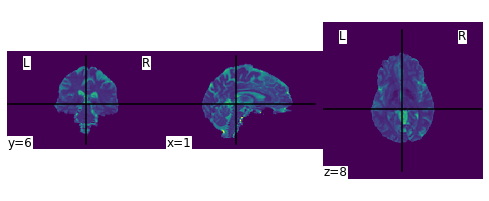

In [ ]:
#example
#usage:

# visualize B0 DWI:
b0dwi = nb.load('outputs/b0_dwi_brain.nii.gz')  # display dwi
b0dwi_data = b0dwi.get_fdata()
img = new_img_like(b0dwi, b0dwi_data, affine=b0dwi.affine, copy_header=True)
_ = plotting.plot_img(img)

## Align DWI to ACPC MNI Space:

In [ ]:
#exporti

class TransConvertInputSpec(PipetographyBaseInputSpec):
    flirt_xfm = File(
        exists=True,
        argstr="%s",
        desc="flirt transformation matrix",
        position=0,
        xor = ['itk_xfm']
    )
    flirt_in = File(
        exists=True,
        argstr="%s",
        desc="flirt input file",
        position=1,
        xor = ['itk_xfm']
    )
    flirt_ref = File(
        exists=True,
        argstr="%s",
        desc="flirt reference image",
        position=2,
        xor = ['itk_xfm']
    )
    itk_xfm = File(
        exists=True,
        argstr="%s",
        desc="itk transformation file",
        position=0,
        xor=['flirt_xfm','flirt_in','flirt_ref']
    )
    flirt = traits.Bool(
        argstr="flirt_import",
        desc="Apply transformation conversion to flirt output",
        position = 3,
        xor=["itk"]
    )
    itk = traits.Bool(
        argstr="itk_import",
        desc="Apply transformation conversion to itk output",
        position=3,
        xor=["flirt"]
    )
    out_file = File(
        argstr="%s",
        mandatory=True,
        position=4,
        desc="output mrtrix3 transformation matrix"
    )

class TransConvertOutputSpec(TraitedSpec):
    out_file=File(desc="output mrtrix3 transformation matrix")

class TransConvert(CommandLine):
    _cmd = 'transformconvert'
    input_spec=TransConvertInputSpec
    output_spec=TransConvertOutputSpec
    def _list_outputs(self):
        outputs = self.output_spec().get()
        outputs["out_file"] = os.path.abspath(self.inputs.out_file)
        return outputs


class MRTransformInputSpec(PipetographyBaseInputSpec):
    linear_xfm = File(
        argstr="-linear %s",
        position=0,
        desc="input linear affine transformation matrix"
    )
    in_file = File(
        argstr="%s",
        mandatory=True,
        position=1,
        desc="input image"
    )
    out_file = File(
        argstr="%s",
        mandatory=True,
        position=2,
        desc="output image"
    )

class MRTransformOutputSpec(TraitedSpec):
    out_file = File(desc="Transformed image")

class MRTransform(CommandLine):
    """Apply spatial transformations to an image"""
    _cmd = 'mrtransform'
    input_spec=MRTransformInputSpec
    output_spec=MRTransformOutputSpec
    def _list_outputs(self):
        outputs=self.output_spec().get()
        outputs["out_file"] = os.path.abspath(self.inputs.out_file)
        return outputs

bet outputs/acpc_t1.nii outputs/acpc_t1_brain -R -B -m
epi_reg --noclean --epi=outputs/b0_dwi_brain.nii.gz --t1=outputs/acpc_t1.nii --t1brain=outputs/acpc_t1_brain.nii.gz --out=outputs/dwi2acpc
transformconvert outputs/dwi2acpc.mat outputs/b0_dwi_brain.nii.gz outputs/acpc_t1_brain.nii.gz flirt_import outputs/dwi2acpc_xfm.mat -force
mrtransform -linear outputs/dwi2acpc_xfm.mat outputs/dwi_norm.mif outputs/dwi_acpc.mif
mrconvert: [WARNING] existing output files will be overwritten
mrconvert: [WARNING] image "outputs/dwi_acpc.nii.gz" contains non-rigid transform - qform will not be stored.
mrconvert: [100%] copying from "outputs/dwi_acpc.mif" to "outputs/dwi_acpc.nii.gz"
mrconvert: [100%] compressing image "outputs/dwi_acpc.nii.gz"


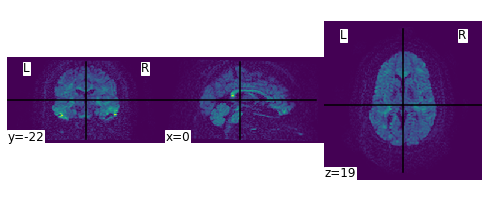

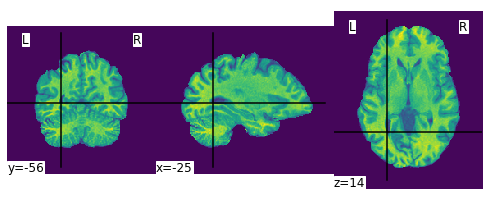

In [ ]:
#example
#usage

# first we extract the brain with FSL:
FSL_BET = fsl.preprocess.BET()
FSL_BET.inputs.in_file = 'outputs/acpc_t1.nii'
FSL_BET.inputs.out_file = 'outputs/acpc_t1_brain'
FSL_BET.inputs.args = '-R -B -m'
print(FSL_BET.cmdline)
FSL_BET.run()

# perform alignment of DWI to ANAT, get transformation matrix with EPIREG
EPI_REG = fsl.epi.EpiReg()
EPI_REG.inputs.epi = 'outputs/b0_dwi_brain.nii.gz'
EPI_REG.inputs.t1_head = 'outputs/acpc_t1.nii'
EPI_REG.inputs.t1_brain = 'outputs/acpc_t1_brain.nii.gz'
EPI_REG.inputs.out_base = 'outputs/dwi2acpc'
print(EPI_REG.cmdline)
EPI_REG.run()

# apply transformation in mrtrix:
acpc_xfm = TransConvert()
acpc_xfm.inputs.flirt_xfm = 'outputs/dwi2acpc.mat'
acpc_xfm.inputs.flirt_in = 'outputs/b0_dwi_brain.nii.gz'
acpc_xfm.inputs.flirt_ref = 'outputs/acpc_t1_brain.nii.gz'
acpc_xfm.inputs.flirt=True
acpc_xfm.inputs.out_file = 'outputs/dwi2acpc_xfm.mat'
acpc_xfm.inputs.force=True
print(acpc_xfm.cmdline)
acpc_xfm.run()

Apply_xfm = MRTransform()
Apply_xfm.inputs.linear_xfm = 'outputs/dwi2acpc_xfm.mat'
Apply_xfm.inputs.in_file = 'outputs/dwi_norm.mif'
Apply_xfm.inputs.out_file = 'outputs/dwi_acpc.mif'
print(Apply_xfm.cmdline)
Apply_xfm.run()

!mrconvert outputs/dwi_acpc.mif outputs/dwi_acpc.nii.gz -force
# visualize, our dwi should be in same space as anat/mni152:
adwi = nb.load('outputs/dwi_acpc.nii.gz')  # display dwi
adwi_data = adwi.get_fdata()[:,:,:,3]
adwi_img = new_img_like(adwi, adwi_data, affine=adwi.affine, copy_header=True)
_ = plotting.plot_img(adwi_img)

anatbrain = nb.load('outputs/acpc_t1_brain.nii.gz')
anatbrain_data=anatbrain.get_fdata()
ab_img = new_img_like(anatbrain, anatbrain_data, affine=anatbrain.affine, copy_header=True)
_ = plotting.plot_img(ab_img)

In [ ]:
#exporti
class WMBinarizeInputSpec(CommandLineInputSpec):
    in_file = File(
        exists=True,
        mandatory=True,
        argstr="--i %s",
        desc="Input aseg.mgz freesurfer recon-all output",
        position=0,
    )
    out_file = File(
        argstr="--o %s",
        desc="output WM binary mask",
        position = 1
    )
    all_wm = traits.Bool(
        argstr="--all-wm",
        desc="set match vals to 2, 41, 77, 251-255, 7, and 46, (aseg for all WM)",
        position = 2
    )
    
class WMBinarizeOutputSpec(TraitedSpec):
    out_file = File(desc="Output white matter mask")
    
class WMBinarize(CommandLine):
    """
    mri_binarize
    """
    _cmd = 'mri_binarize'
    input_spec = WMBinarizeInputSpec
    output_spec = WMBinarizeOutputSpec
    def _list_outputs(self):
        outputs=self.output_spec().get()
        outputs["out_file"] = os.path.abspath(self.inputs.out_file)
        return outputs

In [ ]:
#example
#usage

get_wmmask = WMBinarize()
get_wmmask.inputs.in_file = 'outputs/freesurfer/recon_all/mri/aseg.mgz'
get_wmmask.inputs.out_file = 'outputs/fs_wm_mask.nii.gz'
get_wmmask.inputs.all_wm = True
print(get_wmmask.cmdline)

mri_binarize --i outputs/freesurfer/recon_all/mri/aseg.mgz --o outputs/fs_wm_mask.nii.gz --all-wm


## Reslice to ACPC MNI152 space voxel resolution with `mrregrid`:
This is mainly done to isotropically upsample your DWI data to a higher resolution, like the MNI template or your T1/T2 image voxel grid. Partial upsampling is not recommended (resolution that's not MNI template).

In [ ]:
#exporti
class MRRegridInputSpec(PipetographyBaseInputSpec):
    in_file = File(
        exists=True,
        mandatory=True,
        argstr="%s",
        desc="Input file to be resliced",
        position=0,
    )
    regrid = File(
        exists=True,
        argstr="regrid -template %s",
        desc="Regrid to template voxel grid size",
        position=1
    )
    out_file = File(
        argstr="%s",
        desc="output image",
        position=2
    )
    args = traits.Str(
        argstr="%s",
        desc="additional arguments",
        position = -1
    )


class MRRegridOutputSpec(TraitedSpec):
    out_file = File(desc="Output image")


class MRRegrid(CommandLine):
    """
    `mrgrid`'s regrid option'
    """
    _cmd = 'mrgrid'
    input_spec = MRRegridInputSpec
    output_spec = MRRegridOutputSpec
    def _list_outputs(self):
        outputs=self.output_spec().get()
        outputs["out_file"] = os.path.abspath(self.inputs.out_file)
        return outputs

In [ ]:
#example
#usage

temp_ref = os.path.expandvars('$FSLDIR/data/standard/MNI152_T1_1mm.nii.gz')
reslice = MRRegrid()
reslice.inputs.in_file = 'outputs/dwi_acpc.mif'
reslice.inputs.regrid = temp_ref
reslice.inputs.out_file = 'outputs/dwi_acpc_1mm.mif'
print(reslice.cmdline)
reslice.run()

mrgrid outputs/dwi_acpc.mif regrid -template /usr/local/fsl/data/standard/MNI152_T1_1mm.nii.gz outputs/dwi_acpc_1mm.mif


### Recreate final DWI/Gradients/Reference images: 
First we create output space (MNI) B0 volumes and masks:

In [ ]:
#example
#usage

# extract B0 volume
mniB0Extract = DWIExtract()
mniB0Extract.inputs.bzero = True
mniB0Extract.inputs.in_file = 'outputs/dwi_acpc_1mm.mif' # intensity normalized dwi volume
mniB0Extract.inputs.out_file = 'outputs/dwi_acpc_1mm_b0.mif'
mniB0Extract.run()

# find mean B0 volume
mniB0Mean = MRMath()
mniB0Mean.inputs.operation = 'mean'
mniB0Mean.inputs.in_file = 'outputs/dwi_acpc_1mm_b0.mif'
mniB0Mean.inputs.axis = 3
mniB0Mean.inputs.out_file = 'outputs/dwi_acpc_1mm_b0_mean.mif'
mniB0Mean.run()

# create DWI mask in MNI output space
B0Mask = BrainMask()
B0Mask.inputs.in_file = 'outputs/dwi_acpc_1mm.mif'
B0Mask.inputs.out_file = 'outputs/dwi_acpc_1mm_mask.mif'
B0Mask.run()

# convert B0 volume and DWI mask to nifti format
# do a simple conversion here, will be replaced with Nodes in pipeline
!mrconvert outputs/dwi_acpc_1mm_b0_mean.mif outputs/dwi_acpc_1mm_b0_mean.nii.gz -force
!mrconvert outputs/dwi_acpc_1mm_mask.mif outputs/dwi_acpc_1mm_mask.nii.gz -force

# apply mask to B0 volume to create B0 brain images
FSL_mask = fsl.ApplyMask()
FSL_mask.inputs.in_file = 'outputs/dwi_acpc_1mm_b0_mean.nii.gz'
FSL_mask.inputs.mask_file = 'outputs/dwi_acpc_1mm_mask.nii.gz'
FSL_mask.inputs.out_file = 'outputs/dwi_acpc_1mm_brain.nii.gz'
FSL_mask.run()

# Produce final images and gradients:
ConvertOutput = Convert()
ConvertOutput.inputs.in_file = 'outputs/dwi_acpc_1mm.mif'
ConvertOutput.inputs.out_file = 'outputs/dwi_acpc_1mm.nii.gz'
ConvertOutput.inputs.export_grad = True
ConvertOutput.inputs.out_bfile = 'outputs/dwi_acpc_1mm.b'
ConvertOutput.inputs.export_fslgrad = True
ConvertOutput.inputs.out_fslgrad = ('outputs/dwi_acpc.bvecs','outputs/dwi_acpc.bvals')
ConvertOutput.inputs.export_json = True
ConvertOutput.inputs.out_json = 'outputs/dwi_acpc_1mm.json'
ConvertOutput.inputs.force=True
print(ConvertOutput.cmdline)
ConvertOutput.run()

mrconvert: [WARNING] existing output files will be overwritten
mrconvert: [100%] copying from "outputs/dwi_acpc_1mm_b0_mean.mif" to "outputs/dwi_acpc_1mm_b0_mean.nii.gz"
mrconvert: [100%] compressing image "outputs/dwi_acpc_1mm_b0_mean.nii.gz"
mrconvert: [WARNING] existing output files will be overwritten
mrconvert: [WARNING] requested datatype (Bit) not supported - substituting with UInt8
mrconvert: [100%] copying from "outputs/dwi_acpc_1mm_mask.mif" to "outputs/dwi_acpc_1mm_mask.nii.gz"
mrconvert: [100%] compressing image "outputs/dwi_acpc_1mm_mask.nii.gz"
mrconvert outputs/dwi_acpc_1mm.mif outputs/dwi_acpc_1mm.nii.gz -force -export_grad_fsl outputs/dwi_acpc.bvecs outputs/dwi_acpc.bvals -export_grad_mrtrix outputs/dwi_acpc_1mm.b -json_export outputs/dwi_acpc_1mm.json


Now we have all the preprocessing done! Time for tracts!

In [ ]:
#exporti
def mask2seedtuple(mask_file, grid_size):
    seed_grid_tuple = (
        mask_file,
        grid_size,
    )
    return seed_grid_tuple

In [ ]:
#exporti
class tckSIFT2InputSpec(CommandLineInputSpec):
    in_file = File(
        exists=True,
        mandatory=True,
        argstr="%s",
        position=-3,
        desc="input track file"
    )
    in_fod = File(
        exists=True,
        mandatory=True,
        argstr="%s",
        position=-2,
        desc="input image containing the spherical harmonics of the fiber orientation distributions"
    )
    out_file = File(
        mandatory=True,
        argstr="%s",
        desc="output weighting factor for each streamline",
        position=-1
    )
    proc_mask = File(
        exists=True,
        argstr="-proc_mask %s",
        desc="provide an image containing the processing mask weights for the model; image spatial dimensions must match the fixel image"
    )
    act = File(
        exists=True,
        argstr="-act %s",
        desc="use an ACT five-tissue-type segmented anatomical image to derive the processing mask"
    )
    fd_scale_gm = traits.Bool(
        argstr="-fd_scale_gm",
        desc="in conjunction with -act to heuristically downsize the fibre density estimates based on the presence of GM in the voxel. This can assist in reducing tissue interface effects when using a single-tissue deconvolution algorithm"
    )
    nthreads = traits.Int(
        argstr="-nthreads %d",
        desc="number of threads. if zero, the number" " of available cpus will be used",
        nohash=True,
    )
    force = traits.Bool(
        argstr="-force",
        desc="overwrite existing output file"
    )
    
class tckSIFT2OutputSpec(TraitedSpec):
    out_file=File(argstr="%s", desc="output text file containing the weighting factor for each streamline")
    
class tckSIFT2(CommandLine):
    """
    Interface with mrtrix3 package
    Spherical-deconvolution informed filtering of tractograms - sift2
    Optimise per-streamline cross-section multipliers to match a whole-brain tractogram to fixel-wise fibre densities
    """
    _cmd="tcksift2"
    input_spec=tckSIFT2InputSpec
    output_spec=tckSIFT2OutputSpec
    
    def _list_outputs(self):
        outputs=self.output_spec().get()
        outputs["out_file"] = os.path.abspath(self.inputs.out_file)
        return outputs

In [ ]:
#usage
#example

sift2 = tckSIFT2()
sift2.inputs.in_file = '/Users/xxie/sample_data/dwipreproc/cuda_tracking/_session_id_002_subject_id_01/sub-01_ses-002_gmwmi2wm.tck'
sift2.inputs.in_fod = 'outputs/wmfod.mif'
sift2.inputs.act = 'outputs/5tt.mif'
sift2.inputs.fd_scale_gm = True
sift2.inputs.out_file = 'outputs/sift2.txt'
sift2.inputs.force=True
print(sift2.cmdline)
sift2.run()

tcksift2 -act outputs/5tt.mif -fd_scale_gm -force /Users/xxie/sample_data/dwipreproc/cuda_tracking/_session_id_002_subject_id_01/sub-01_ses-002_gmwmi2wm.tck outputs/wmfod.mif outputs/sift2.txt
201006-09:06:56,480 nipype.interface INFO:
	 stderr 2020-10-06T09:06:56.480315:tcksift2: [WARNING] existing output files will be overwritten
201006-09:07:55,809 nipype.interface INFO:
tcksift2: [100%] resampling ACT 5TT image to fixel image space
201006-09:10:18,186 nipype.interface INFO:
tcksift2: [100%] segmenting FODs
201006-09:13:36,209 nipype.interface INFO:
tcksift2: [100%] mapping tracks to image
201006-09:13:40,264 nipype.interface INFO:
	 stderr 2020-10-06T09:13:40.264178:tcksift2:   Iteration     CF (data)      CF (reg)     Streamlines
201006-09:24:54,880 nipype.interface INFO:
tcksift2: [done]        47        12.671%         1.106%        9342006..
201006-09:24:54,883 nipype.interface INFO:
tcksift2: [done]        47        12.671%         1.106%        9342006


### Tweak Atlas labels with look up tables.

mrtrix3's `labelconvert` and `labelsgmfix` if using freesurfer atlas.

Use the nipype interface for `LabelConvert`, and declare a mrtrix3 path to its `/share/mrtrix3/labelconvert/` folder where the target connectome lookup tabel for output images reside. Available files include: 

    - aal.txt
    - aal2.txt
    - fs_default.txt
    - hcpmmp1_ordered.txt
    - hcpmmp1_original.txt
    - lpba40.txt
    - fs2lobes_cinginc_convert.txt
    - fs2lobes_cinginc_labels.txt
    - fs2lobes_cingsep_convert.txt
    - fs2lobes_cingsep_labels.txt
    
Please refer to https://mrtrix.readthedocs.io/en/latest/quantitative_structural_connectivity/labelconvert_tutorial.html#labelconvert-tutorial for detailed explanation.

### `tck2connectome` for connectivity matrix and distance adjacency matrix

Connectivity matrix first:

In [ ]:
#exporti
class MakeConnectomeInputSpec(CommandLineInputSpec):
    """
    Specifying inputs to mrtrix3's tck2connectome
    """
    in_file = File(
        exists=True, mandatory=True, argstr="%s", position=-3, desc="input tck file"
    )
    in_parc = File(
        exists=True, argstr="%s", position=-2, desc="parcellation file"
    )
    out_file = File(
        argstr="%s",
        mandatory=True,
        position=-1,
        desc="output file connectivity csv file",
    )
    nthreads = traits.Int(
        argstr="-nthreads %d",
        desc="number of threads. if zero, the number" " of available cpus will be used",
        nohash=True,
    )
    in_weights = File(
        exists=True,
        argstr="-tck_weights_in %s",
        desc="specify a text scalar file containing the streamline weights",
    )
    scale_length=traits.Bool(
        argstr="-scale_length",
        desc="scale each contribution to the connectome edge by the length of the streamline"
    )
    stat_edge=traits.Enum(
        "sum",
        "mean",
        "min",
        "max",
        argstr="-stat_edge %s",
        desc="statistic for combining the values from all streamlines in an edge into a single scale value for that edge (options are: sum,mean,min,max;default=sum)"
    )
    symmetric=traits.Bool(
        argstr='-symmetric',
        desc='make matrices symmetric'
    )
    zero_diag=traits.Bool(
        argstr='-zero_diagonal',
        desc='set matrix diagonal to zero on output'
    )
    force = traits.Bool(
        argstr='-force',
        desc='overwrite existing output file'
    )
    
class MakeConnectomeOutputSpec(TraitedSpec):
    out_file = File(argstr="%s", desc="output connectome csv file")
    
class MakeConnectome(CommandLine):
    """
    mrtrix3's tck2connectome interface, defaults to zero diagonal and symmetric outputs.
    """
    _cmd="tck2connectome"
    input_spec = MakeConnectomeInputSpec
    output_spec = MakeConnectomeOutputSpec
    
    def _list_outputs(self):
        outputs=self.output_spec().get()
        outputs["out_file"] = os.path.abspath(self.inputs.out_file)
        return outputs

In [ ]:
#usage
#example

connectivity = MakeConnectome()
connectivity.inputs.in_file = '/Users/xxie/sample_data/dwipreproc/cuda_tracking/_session_id_002_subject_id_01/sub-01_ses-002_gmwmi2wm.tck'
connectivity.inputs.in_parc = 'outputs/atlas_in_dwi_syn_int.nii.gz'
connectivity.inputs.out_file = 'outputs/connectome.csv'
connectivity.inputs.in_weights = 'outputs/sift2.txt'
connectivity.inputs.symmetric = True
connectivity.inputs.zero_diag = True
connectivity.inputs.force = True
print(connectivity.cmdline)
connectivity.run()

tck2connectome -force -tck_weights_in outputs/sift2.txt -symmetric -zero_diagonal /Users/xxie/sample_data/dwipreproc/cuda_tracking/_session_id_002_subject_id_01/sub-01_ses-002_gmwmi2wm.tck outputs/atlas_in_dwi_syn_int.nii.gz outputs/connectome.csv
201006-09:49:58,950 nipype.interface INFO:
	 stderr 2020-10-06T09:49:58.950005:tck2connectome: [WARNING] existing output files will be overwritten
201006-09:49:58,951 nipype.interface INFO:
	 stderr 2020-10-06T09:49:58.950005:tck2connectome: Image "outputs/atlas_in_dwi_syn_int.nii.gz" stored with floating-point type; need to check for non-integer or negative values
201006-09:49:59,16 nipype.interface INFO:
tck2connectome: [100%] uncompressing image "outputs/atlas_in_dwi_syn_int.nii.gz"
201006-09:49:59,80 nipype.interface INFO:
tck2connectome: [100%] Verifying parcellation image
201006-09:49:59,129 nipype.interface INFO:
tck2connectome: [100%] uncompressing image "outputs/atlas_in_dwi_syn_int.nii.gz"
201006-09:50:41,959 nipype.interface INFO:


Distance adjacency matrix:

In [ ]:
#usage
#example

distance = MakeConnectome()
distance.inputs.in_file = '/Users/xxie/sample_data/dwipreproc/cuda_tracking/_session_id_002_subject_id_01/sub-01_ses-002_gmwmi2wm.tck'
distance.inputs.in_parc = 'outputs/atlas_in_dwi_syn_int.nii.gz'
distance.inputs.out_file = 'outputs/distances.csv'
distance.inputs.scale_length = True
distance.inputs.stat_edge = 'mean'
distance.inputs.symmetric = True
distance.inputs.zero_diag = True
distance.inputs.force = True
print(distance.cmdline)
distance.run()

tck2connectome -force -scale_length -stat_edge mean -symmetric -zero_diagonal /Users/xxie/sample_data/dwipreproc/cuda_tracking/_session_id_002_subject_id_01/sub-01_ses-002_gmwmi2wm.tck outputs/atlas_in_dwi_syn_int.nii.gz outputs/distances.csv
201006-09:50:50,96 nipype.interface INFO:
	 stderr 2020-10-06T09:50:50.096641:tck2connectome: [WARNING] existing output files will be overwritten
201006-09:50:50,98 nipype.interface INFO:
	 stderr 2020-10-06T09:50:50.098551:tck2connectome: Image "outputs/atlas_in_dwi_syn_int.nii.gz" stored with floating-point type; need to check for non-integer or negative values
201006-09:50:50,165 nipype.interface INFO:
tck2connectome: [100%] uncompressing image "outputs/atlas_in_dwi_syn_int.nii.gz"
201006-09:50:50,233 nipype.interface INFO:
tck2connectome: [100%] Verifying parcellation image
201006-09:50:50,288 nipype.interface INFO:
tck2connectome: [100%] uncompressing image "outputs/atlas_in_dwi_syn_int.nii.gz"
201006-09:51:23,174 nipype.interface INFO:
tck2c

Visualize:

<ipython-input-47-b01e39945f7b>:12: RuntimeWarning: divide by zero encountered in log10
  cdk=ax1.imshow(np.log10(CM), cmap = plt.get_cmap('inferno'), interpolation = 'nearest')


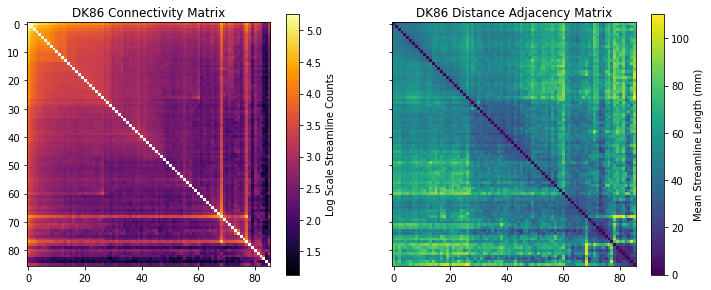

In [ ]:
#usage
#example

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# load matrices:
CM = pd.read_csv('outputs/connectome.csv', header = None)
DM = pd.read_csv('outputs/distances.csv', header = None)

# Visualize:
fig, (ax1, ax2) = plt.subplots(1,2, sharey = True, figsize = (12,12))
# log1p - calculates log(1+x)
cdk=ax1.imshow(np.log10(CM), cmap = plt.get_cmap('inferno'), interpolation = 'nearest')
ax1.set_title('DK86 Connectivity Matrix')
cbar=fig.colorbar(cdk, ax=ax1, shrink=0.4)
cbar.set_label('Log Scale Streamline Counts')

ddk=ax2.imshow(DM, interpolation = 'nearest')
ax2.set_title('DK86 Distance Adjacency Matrix')
dbar=fig.colorbar(ddk, ax=ax2, shrink=0.4)
dbar.set_label('Mean Streamline Length (mm)')